# Get the Rating Matrix

In [102]:
# !pip install apyori

In [103]:
# !pip install mlxtend  

In [104]:
# !pip install efficient-apriori

In [105]:
import pandas as pd 
data_with_3 = pd.read_csv("../datasets/ratings_with_3_combinations.csv")[["rating", "bill"]]

data_with_3.head()

,rating,bill
0,1,"(745321, 666652)"
1,1,"(745321, 751782)"
2,10,"(745321, 751839)"
3,1,"(666652, 751782)"
4,1,"(666652, 751839)"


In [106]:
data_3_greater_1 = data_with_3[data_with_3.rating > 1] 

data_3_greater_1.head() 

,rating,bill
2,10,"(745321, 751839)"
5,151,"(751782, 751839)"
10,107,"(751873, 760125)"
11,12,"(772494, 754574)"
13,11,"(772494, 749358)"


In [107]:
len(data_with_3), len(data)

(5216080, 771062)

In [108]:
data.describe()

,option_x,option_y,rating
count,771062.000000,771062.000000,771062.000000
mean,735325.372226,735395.857417,2.418680
std,42364.768430,42085.392109,9.794105
min,16329.000000,10494.000000,1.000000
25%,714744.000000,714645.000000,1.000000
50%,751526.000000,751358.000000,1.000000
75%,760344.000000,760209.000000,2.000000
max,823758.000000,823758.000000,2254.000000


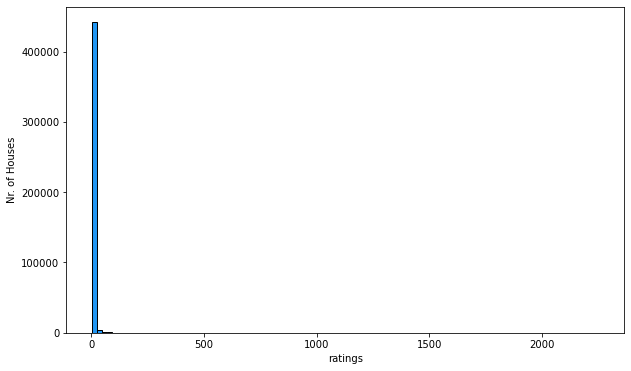

In [109]:
# If the distribution of the quantity is normal, then it should be standardized, otherwise, the data should be normalized.
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
plt.hist(data_3_greater_1['rating'], bins=100, ec='black', color='#2196f3')
plt.xlabel('ratings')
plt.ylabel('Nr. of Houses')
plt.show()

In [110]:
max(data_3_greater_1.rating),  min(data_3_greater_1.rating)

(2254, 2)

c:\Users\melih.kacaman\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

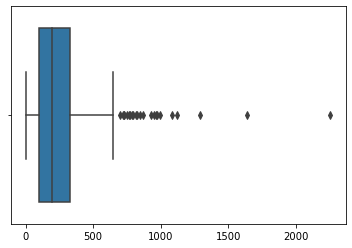

In [111]:
import seaborn as sns
sns.boxplot(data_3_greater_1['rating'].unique())

In [112]:
import numpy as np
data_3_greater_1_log = data_3_greater_1.copy() 
data_3_greater_1_log["rating"] = np.log(data_3_greater_1.rating) 

data_3_greater_1_log.head() 

,rating,bill
2,2.302585,"(745321, 751839)"
5,5.017280,"(751782, 751839)"
10,4.672829,"(751873, 760125)"
11,2.484907,"(772494, 754574)"
13,2.397895,"(772494, 749358)"


In [113]:
max(data_3_greater_1_log.rating),  min(data_3_greater_1_log.rating)

(7.720461694599722, 0.6931471805599453)

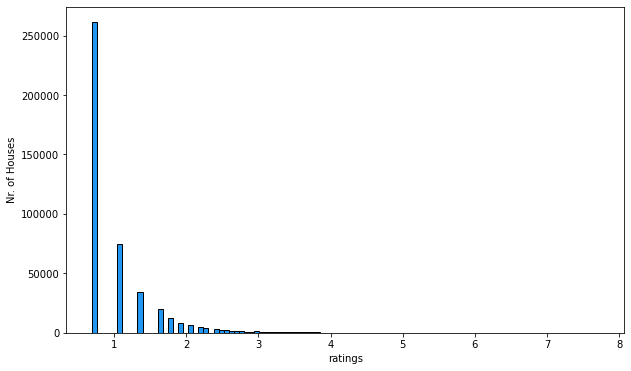

In [114]:
# If the distribution of the quantity is normal, then it should be standardized, otherwise, the data should be normalized.
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
plt.hist(data_3_greater_1_log['rating'], bins=100, ec='black', color='#2196f3')
plt.xlabel('ratings')
plt.ylabel('Nr. of Houses')
plt.show()

c:\Users\melih.kacaman\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

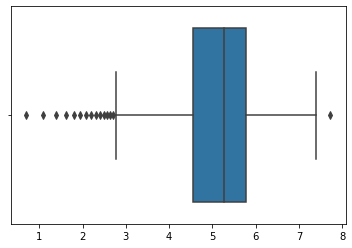

In [115]:
import seaborn as sns
sns.boxplot(data_3_greater_1_log['rating'].unique())

In [116]:
import numpy as np 
Q1 = np.percentile(data_3_greater_1_log['rating'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(data_3_greater_1_log['rating'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

print("data_3_greater_1_log has IQR:", IQR) 

data_3_greater_1_log has IQR: 0.6931471805599453


In [117]:
import pandas as pd
data_raw = pd.read_csv("../datasets/raw_data.csv") 

In [118]:
data_raw.head() 

,Unnamed: 0,optionId,bill
0,0,751839,1
1,1,751782,1
2,2,745321,1
3,3,666652,1
4,4,751873,2


In [119]:
data_raw

,Unnamed: 0,optionId,bill
0,0,751839,1
1,1,751782,1
2,2,745321,1
3,3,666652,1
4,4,751873,2
...,...,...,...
1023028,1023028,764458,326055
1023029,1023029,764905,326056
1023030,1023030,774483,326056
1023031,1023031,752244,326057


In [120]:
transactions = [] 

bill = 1
option_bill = [] 

for index,row in data_raw.iterrows(): 
    if(row.bill == bill):
        option_bill.append(row.optionId)
    else:
        bill = row.bill 
        transactions.append(tuple(set(option_bill))) 
        option_bill.clear()
        option_bill.append(row.optionId)  


transactions[:3]

# Model 1: Matrix Factorization Using Keras 

#### Data Prep for MF 

In [ ]:
data_3_greater_1_log.head() 

,rating,bill
2,2.302585,"(745321, 751839)"
5,5.017280,"(751782, 751839)"
10,4.672829,"(751873, 760125)"
11,2.484907,"(772494, 754574)"
13,2.397895,"(772494, 749358)"


In [ ]:
data_3_greater_1_log.bill.unique().shape

(448529,)

In [ ]:
data_3_greater_1_log.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448529 entries, 2 to 5215140
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rating  448529 non-null  float64
 1   bill    448529 non-null  object 
dtypes: float64(1), object(1)
memory usage: 10.3+ MB


In [ ]:
from ast import literal_eval

data_3_greater_1_log.bill = data_3_greater_1_log.bill.apply(literal_eval) 
data_3_greater_1_log.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448529 entries, 2 to 5215140
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rating  448529 non-null  float64
 1   bill    448529 non-null  object 
dtypes: float64(1), object(1)
memory usage: 10.3+ MB


In [ ]:
type(data_3_greater_1_log.bill.iat[0])

tuple

In [ ]:
statement = (772494, 754574, 749358) 
s_set = set(statement) 
tuple(s_set.difference([772494]))

(749358, 754574)

In [ ]:
def split_bill(statement):
    return [
        (tuple(set(statement).difference([statement[0]])), statement[0]),
        (tuple(set(statement).difference([statement[1]])), statement[1]),
        (tuple(set(statement).difference([statement[2]])), statement[2])
    ]

In [ ]:
data_3_greater_1_log["option_count"] = data_3_greater_1_log.bill.apply(lambda x: len(x))
data_3_greater_1_log.tail() 

,rating,bill,option_count
5211482,0.693147,"(774694, 767718, 767721)",3
5213307,0.693147,"(774590, 774319)",2
5213311,0.693147,"(774469, 774590, 774319)",3
5213576,0.693147,"(764896, 786771, 774571)",3
5215140,0.693147,"(748899, 748868, 752949)",3


In [ ]:
sublist_by_2 = data_3_greater_1_log[data_3_greater_1_log.option_count == 2]

In [ ]:
sublist_by_2_concat = pd.concat([
    sublist_by_2,
    pd.DataFrame(data_3_greater_1_log[data_3_greater_1_log.option_count == 2].bill.to_list(), columns=["LHS", "RHS"], index=sublist_by_2.index)
], axis=1)
sublist_by_2_concat.head()

,rating,bill,option_count,LHS,RHS
2,2.302585,"(745321, 751839)",2,745321,751839
5,5.017280,"(751782, 751839)",2,751782,751839
10,4.672829,"(751873, 760125)",2,751873,760125
11,2.484907,"(772494, 754574)",2,772494,754574
13,2.397895,"(772494, 749358)",2,772494,749358


In [ ]:
sublist_by_3 = data_3_greater_1_log[data_3_greater_1_log.option_count == 3]
sublist_by_3.head() 

,rating,bill,option_count
22,0.693147,"(772494, 754574, 749358)",3
28,0.693147,"(754574, 745328, 745310)",3
44,1.098612,"(751649, 751591, 751532)",3
45,0.693147,"(751649, 751591, 751597)",3
46,0.693147,"(751649, 751595, 751532)",3


In [ ]:
replicated_rows = pd.DataFrame(np.repeat(sublist_by_3.values, 3, axis=0), columns=sublist_by_3.columns)

sublists_by_3_reduced = []  
for item in sublist_by_3.bill.to_list():
    sublists_by_3_reduced += split_bill(item) 

sublists_by_3_reduced = pd.DataFrame(sublists_by_3_reduced, columns=["LHS", "RHS"])

sublist_by_3_concat = pd.concat([
    replicated_rows, 
    sublists_by_3_reduced
], axis=1)

sublist_by_3_concat.head() 

,rating,bill,option_count,LHS,RHS
0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494
1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574
2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358
3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574
4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328


In [ ]:
dataset_combined_MF = pd.concat([sublist_by_3_concat, sublist_by_2_concat], axis=0, ignore_index=True)
dataset_combined_MF.head()  

,rating,bill,option_count,LHS,RHS
0,0.693147,"(772494, 754574, 749358)",3,"(749358, 754574)",772494
1,0.693147,"(772494, 754574, 749358)",3,"(749358, 772494)",754574
2,0.693147,"(772494, 754574, 749358)",3,"(754574, 772494)",749358
3,0.693147,"(754574, 745328, 745310)",3,"(745328, 745310)",754574
4,0.693147,"(754574, 745328, 745310)",3,"(745310, 754574)",745328


In [ ]:
dataset_combined_MF.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859833 entries, 0 to 859832
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   rating        859833 non-null  object
 1   bill          859833 non-null  object
 2   option_count  859833 non-null  object
 3   LHS           859833 non-null  object
 4   RHS           859833 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 32.8+ MB


In [ ]:
sublist_by_2_concat["LHS_C"] = sublist_by_2_concat.LHS.astype('category').cat.codes.values
sublist_by_2_concat["RHS_C"] = sublist_by_2_concat.RHS.astype('category').cat.codes.values

sublist_by_2_concat.head() 

,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
2,2.302585,"(745321, 751839)",2,745321,751839,2524,3071
5,5.017280,"(751782, 751839)",2,751782,751839,3019,3071
10,4.672829,"(751873, 760125)",2,751873,760125,3039,3746
11,2.484907,"(772494, 754574)",2,772494,754574,4308,3518
13,2.397895,"(772494, 749358)",2,772494,749358,4308,2816


In [ ]:
len(sublist_by_2_concat.RHS_C.unique()), len(sublist_by_2_concat.LHS_C.unique())

(5090, 5042)

### Building MF Model 

In [ ]:
from tensorflow import keras
from keras.optimizers import Adam 

n_rhs, n_lhs = len(sublist_by_2_concat.RHS_C.unique()), len(sublist_by_2_concat.LHS_C.unique())
n_latent_factors = 20
# input, embedding --> 
lhs_input = keras.layers.Input(shape=(1,), name="lhs-item") 
lhs_embedding = keras.layers.Embedding(n_lhs + 1, n_latent_factors, name="lhs-embeddings")(lhs_input) 
lhs_vec = keras.layers.Flatten(name="flatten-lhs")(lhs_embedding) 

rhs_input= keras.layers.Input(shape=(1,), name="rhs-item")
rhs_embedding = keras.layers.Embedding(n_rhs + 1, n_latent_factors, name="rhs-embeddings")(rhs_input) 
rhs_vec = keras.layers.Flatten(name="flatten-rhs")(rhs_embedding)

product = keras.layers.dot([lhs_vec, rhs_vec], axes=1, name="dot-product") 

model = keras.Model([lhs_input, rhs_input], product) 


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lhs-item (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 rhs-item (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 lhs-embeddings (Embedding)     (None, 1, 20)        100860      ['lhs-item[0][0]']               
                                                                                                  
 rhs-embeddings (Embedding)     (None, 1, 20)        101820      ['rhs-item[0][0]']               
                                                                                            

In [ ]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(sublist_by_2_concat[["RHS_C", "LHS_C"]], sublist_by_2_concat.rating, test_size=0.10) 
X_train[:5], y_train[:5]

(         RHS_C  LHS_C
 3386167   2853   3089
 3631014   4481   2033
 195936    3704   2657
 3220224   4509   4722
 712718    3790   2486,
 3386167    0.693147
 3631014    1.791759
 195936     0.693147
 3220224    0.693147
 712718     2.302585
 Name: rating, dtype: float64)

In [ ]:
len(X_train.RHS_C.unique()), len(X_test.RHS_C.unique())

(5015, 3221)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=3, )

In [ ]:
history = model.fit(
    [X_train.LHS_C, X_train.RHS_C], 
    y_train,
    validation_data=([X_test.LHS_C, X_test.RHS_C], y_test),
    epochs=100, 
    verbose=0,
    callbacks=[early_stopping]
)

In [ ]:
sublist_by_2_concat.rating.max(), sublist_by_2_concat.rating.min() 

(7.720461694599722, 0.6931471805599453)

In [ ]:
model.get_layer(name='lhs-embeddings').get_weights()

[array([[ 0.22056666, -0.16912724,  0.1882681 , ..., -0.17567383,
          0.04895274, -0.21593727],
        [ 0.14937855,  0.04582213,  0.20899996, ...,  0.14795534,
          0.21128191,  0.20954181],
        [ 0.05619259, -0.4132478 ,  0.41646078, ...,  0.42263368,
         -0.29043755,  0.12087945],
        ...,
        [-0.03946779, -0.24141833, -0.02015798, ...,  0.25384787,
         -0.0201466 ,  0.1858632 ],
        [-0.3804089 , -0.63867384, -0.2314779 , ..., -0.7645532 ,
          0.26704714, -0.17474954],
        [-0.0129686 ,  0.04082156, -0.00251633, ...,  0.01406285,
          0.01936612, -0.01009747]], dtype=float32)]

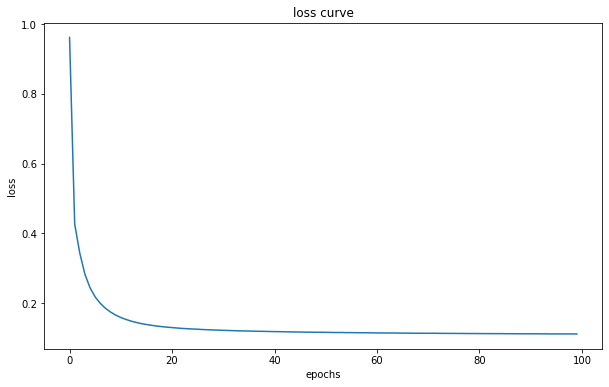

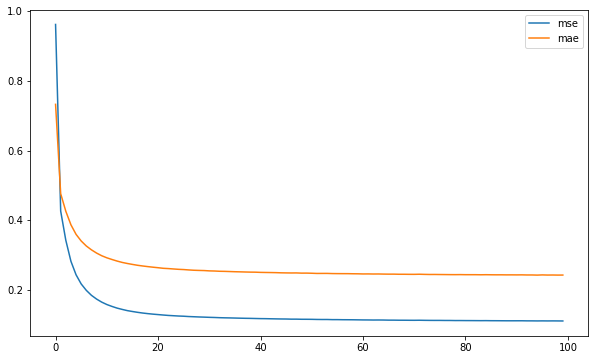

In [ ]:
import matplotlib.pyplot as plt 

plt.title("loss curve")
plt.xlabel("epochs")
plt.ylabel("loss")
pd.DataFrame(history.history)["loss"].plot(figsize=(10,6)) 
pd.DataFrame(history.history)[["mse", "mae"]].plot(figsize=(10,6))
plt.show() 

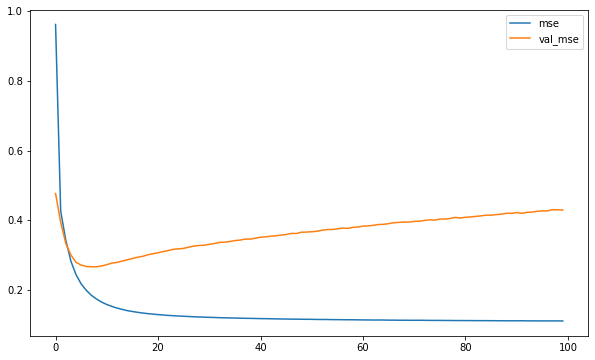

In [72]:
pd.DataFrame(history.history)[["mse", "val_mse"]].plot(figsize=(10,6))
plt.show() 

In [ ]:
# model sıfırlanacak 

In [77]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",patience=3)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
history = model.fit(
    [X_train.LHS_C, X_train.RHS_C], 
    y_train,
    validation_data=([X_test.LHS_C, X_test.RHS_C], y_test),
    epochs=100, 
    callbacks=[early_stopping]
)

Epoch 1/100
6831/6831 [==============================] - 18s 3ms/step - loss: 0.9601 - mae: 0.7317 - mse: 0.9601 - val_loss: 0.4615 - val_mae: 0.4949 - val_mse: 0.4615
Epoch 2/100
6831/6831 [==============================] - 20s 3ms/step - loss: 0.4081 - mae: 0.4657 - mse: 0.4081 - val_loss: 0.3864 - val_mae: 0.4535 - val_mse: 0.3864
Epoch 3/100
6831/6831 [==============================] - 20s 3ms/step - loss: 0.3365 - mae: 0.4223 - mse: 0.3365 - val_loss: 0.3360 - val_mae: 0.4241 - val_mse: 0.3360
Epoch 4/100
6831/6831 [==============================] - 20s 3ms/step - loss: 0.2828 - mae: 0.3875 - mse: 0.2828 - val_loss: 0.3027 - val_mae: 0.4051 - val_mse: 0.3027
Epoch 5/100
6831/6831 [==============================] - 21s 3ms/step - loss: 0.2459 - mae: 0.3624 - mse: 0.2459 - val_loss: 0.2852 - val_mae: 0.3956 - val_mse: 0.2852
Epoch 6/100
6831/6831 [==============================] - 21s 3ms/step - loss: 0.2199 - mae: 0.3435 - mse: 0.2199 - val_loss: 0.2742 - val_mae: 0.3905 - val_mse:

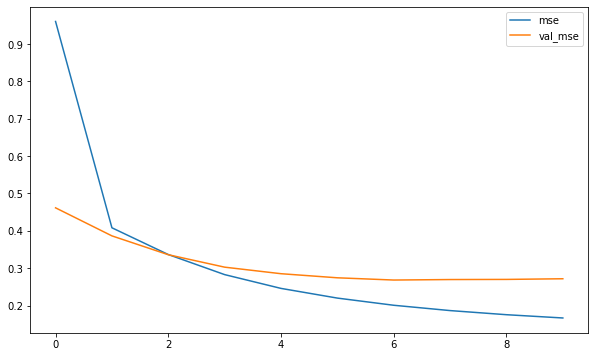

In [78]:
pd.DataFrame(history.history)[["mse", "val_mse"]].plot(figsize=(10,6))
plt.show() 

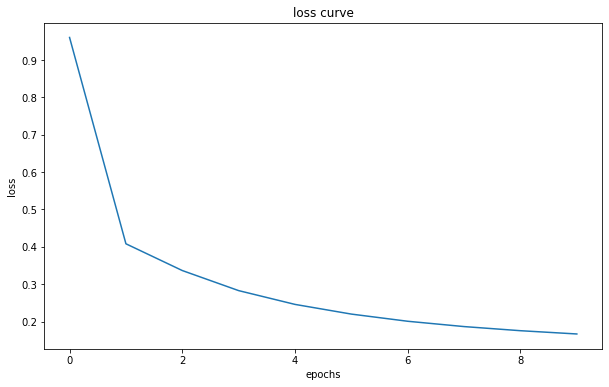

In [80]:
plt.title("loss curve")
plt.xlabel("epochs")
plt.ylabel("loss")
pd.DataFrame(history.history)["loss"].plot(figsize=(10,6)) 
plt.show() 

In [81]:
lhs_embddings = model.get_layer(name='lhs-embeddings').get_weights()[0]
lhs_embddings

array([[-0.21893924, -0.20263046, -0.21311408, ..., -0.09085608,
         0.22564064,  0.21081012],
       [-0.08409597, -0.16130966, -0.13415903, ...,  0.16237012,
         0.1137522 , -0.08933908],
       [-0.1940064 , -0.38253406, -0.2604615 , ...,  0.3090416 ,
         0.3297449 ,  0.2332673 ],
       ...,
       [ 0.14459936,  0.21255964, -0.14122799, ..., -0.29433486,
        -0.197371  ,  0.2865502 ],
       [ 0.08925017,  0.25618383, -0.2737916 , ..., -0.69857854,
        -0.1805903 ,  0.36448234],
       [-0.04731769,  0.0373843 , -0.0154346 , ..., -0.03895541,
         0.00835238,  0.04201813]], dtype=float32)

In [82]:
rhs_embddings = model.get_layer(name='rhs-embeddings').get_weights()[0]
rhs_embddings

array([[ 0.29374182, -0.20776741, -0.2164884 , ...,  0.26009658,
         0.20191579, -0.12583934],
       [-0.1948934 , -0.33365694, -0.3170209 , ...,  0.34563124,
         0.28001878, -0.26498118],
       [-0.20841801, -0.21496305, -0.22991636, ..., -0.06658282,
         0.23185913,  0.21229602],
       ...,
       [ 0.22370306,  0.15964632, -0.1514525 , ...,  0.03617364,
        -0.11841663,  0.6453168 ],
       [-0.12137033,  0.2303722 , -0.3692258 , ..., -0.2752975 ,
        -0.4040136 ,  0.60997313],
       [-0.0492497 , -0.02482485,  0.01861939, ..., -0.01023299,
        -0.00568217, -0.01788526]], dtype=float32)

In [83]:
def recommend(option_in_category, number_of_options=5):
  options = lhs_embddings[option_in_category]@rhs_embddings.T
  mids = np.argpartition(options, -number_of_options)[-number_of_options:]
  
  return mids

In [92]:
sublist_by_2_concat.LHS.value_counts()[:20]

753600    1139
753376    1117
753350     826
525100     809
753536     799
751873     772
753509     744
753609     740
751600     733
778629     708
751754     707
759397     644
753517     639
751526     632
753572     613
716035     579
746304     545
753314     545
760352     544
748802     541
Name: LHS, dtype: int64

In [90]:
sublist_by_2_concat[sublist_by_2_concat.LHS == 778629].head()     # RHS = 721495, LHS = 751839

,rating,bill,option_count,LHS,RHS,LHS_C,RHS_C
2735532,3.091042,"(778629, 751848)",2,778629,751848,4719,3072
2735533,2.890372,"(778629, 753517)",2,778629,753517,4719,3325
2735534,0.693147,"(778629, 751311)",2,778629,751311,4719,2946
2741248,4.262680,"(778629, 778470)",2,778629,778470,4719,4748
2749513,3.218876,"(778629, 703319)",2,778629,703319,4719,1406


In [99]:
id_list = recommend(
    4719,
    5
)

sublist_by_2_concat.query("RHS_C in @id_list").RHS.unique() 


array([702423, 778629, 778581, 778631, 778621], dtype=int64)

In [94]:
id_list

array([1398, 4763, 4762, 4759, 4755], dtype=int64)

# Model 2: Apriori (apyori Module)

In [2]:
from apyori import apriori 

In [9]:
associations = apriori(
    transactions,
    min_length = 2,
    max_length=4,
    min_support = 0.0001,
    min_confidence = 0.0001,
    min_lift = 0.0001,
)

associations = list(associations)
len(associations)

8374

In [10]:
association = associations[100]
print(association)
print("support", association.support)
print(association.ordered_statistics)
print("right", association.ordered_statistics[0].items_add)
print("left", association.ordered_statistics[0].items_base)
print("confidence", association.ordered_statistics[0].confidence)
print("lift", association.ordered_statistics[0].lift)


RelationRecord(items=frozenset({635458}), support=0.0007728733714453959, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({635458}), confidence=0.0007728733714453959, lift=1.0)])
support 0.0007728733714453959
[OrderedStatistic(items_base=frozenset(), items_add=frozenset({635458}), confidence=0.0007728733714453959, lift=1.0)]
right frozenset({635458})
left frozenset()
confidence 0.0007728733714453959
lift 1.0


In [11]:
rules = [] 
for association in associations:
    if len(association.ordered_statistics) > 1: 
        rules.append(association)

In [12]:
len(rules)

5228

In [13]:
rules 

[RelationRecord(items=frozenset({525099, 525100}), support=0.0011010378585273694, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({525099, 525100}), confidence=0.0011010378585273694, lift=1.0), OrderedStatistic(items_base=frozenset({525099}), items_add=frozenset({525100}), confidence=0.24224021592442646, lift=11.800967554677243), OrderedStatistic(items_base=frozenset({525100}), items_add=frozenset({525099}), confidence=0.05363812938891378, lift=11.800967554677243)]),
 RelationRecord(items=frozenset({525099, 701998}), support=0.00010734352381186054, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({525099, 701998}), confidence=0.00010734352381186054, lift=1.0), OrderedStatistic(items_base=frozenset({525099}), items_add=frozenset({701998}), confidence=0.023616734143049933, lift=4.914089258293739), OrderedStatistic(items_base=frozenset({701998}), items_add=frozenset({525099}), confidence=0.022335673261008295, lift=4.91408925